In [ ]:
pip install arabic_reshaper


In [15]:
pip install python-bidi


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pillow


Note: you may need to restart the kernel to use updated packages.


In [3]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ramad\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

C:\Users\ramad\AppData\Local\Temp\ipykernel_35492\2199770878.py:19: FutureWarning: Inferring datetime64[ns, UTC] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns, UTC])
  arabic_data_file = pd.read_excel("All_AR.xlsx")


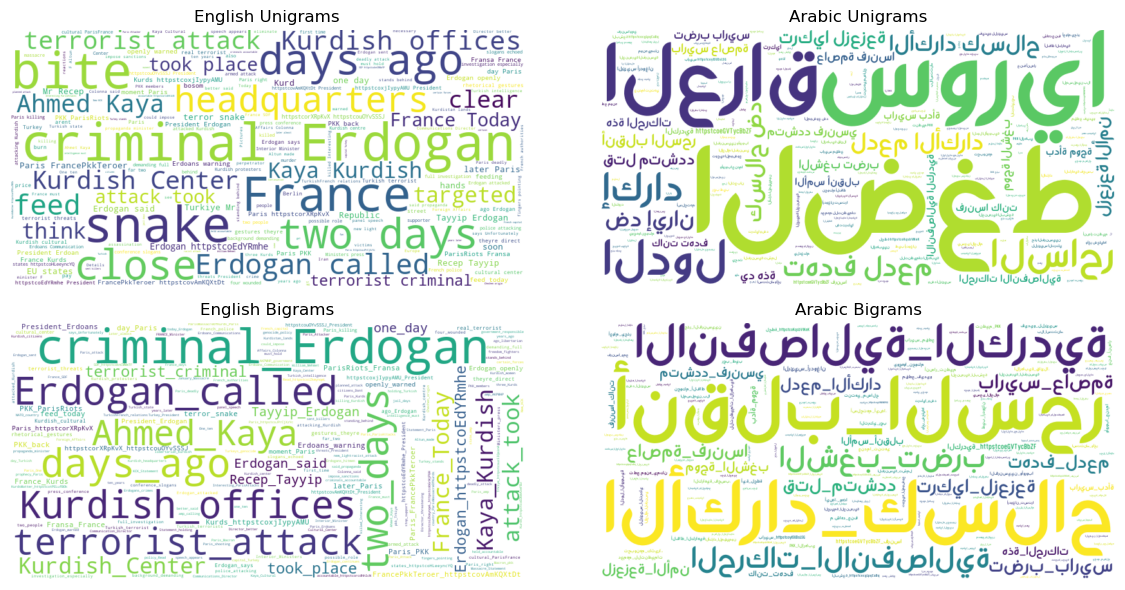

In [23]:
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from collections import Counter

# Loads stopwords for English and Arabic
en_stopwords = set(stopwords.words("english"))
ar_stopwords = set(stopwords.words("arabic"))

# Creates a simple rectangular mask
mask = None  # No mask

# Reads English and Arabic datasets
english_data_file = pd.read_excel("All_EN.xlsx")
arabic_data_file = pd.read_excel("All_AR.xlsx")

# Preprocesses the text
def preprocess_text(text):
    # Removes RT and @ symbols
    text = re.sub(r'RT', '', text)
    text = re.sub(r'@\S+', '', text)

    # Removes non-English/non-Arabic characters
    text = re.sub(r'[^a-zA-Z\u0600-\u06FF\s]', '', text)

    # Removes digits
    text = re.sub(r'\d', '', text)

    # Removes extra whitespace
    text = ' '.join(text.split())

    return text

english_data_file['Tweet'] = english_data_file['Tweet'].apply(preprocess_text)
arabic_data_file['Tweet'] = arabic_data_file['Tweet'].apply(preprocess_text)

# Joins all the preprocessed text into a single string for English and Arabic
english_text = " ".join(english_data_file['Tweet'])
arabic_text = " ".join(arabic_data_file['Tweet'])

# Creates a WordCloud object for unigrams
wordcloud_unigrams_en = WordCloud(
    stopwords=en_stopwords,
    width=800,
    height=400,
    mask=mask,  # No mask
    background_color="white"
).generate(english_text)


arabic_font_path = r"C:\Users\ramad\18 Khebrat Musamim Regular.ttf" # this is my pathfile change it in respect to your path for arabic

wordcloud_unigrams_ar = WordCloud(
    stopwords=ar_stopwords,
    width=800,
    height=400,
    mask=mask,  # No mask
    background_color="white",
    font_path=arabic_font_path  
).generate(arabic_text)

# Create a function to calculate bigram weights
def calculate_bigram_weights(text, stopwords):
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(nltk.word_tokenize(text))
    finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in stopwords)
    finder.apply_freq_filter(2)  
    bigrams = finder.score_ngrams(bigram_measures.raw_freq)

    return {bigram: freq for bigram, freq in bigrams}

# Calculates bigram weights for English and Arabic
bigram_weights_en = calculate_bigram_weights(english_text, en_stopwords)
bigram_weights_ar = calculate_bigram_weights(arabic_text, ar_stopwords)

# Sorts bigram weights by frequency in descending order
sorted_bigrams_en = dict(sorted(bigram_weights_en.items(), key=lambda x: x[1], reverse=True))
sorted_bigrams_ar = dict(sorted(bigram_weights_ar.items(), key=lambda x: x[1], reverse=True))

# Converts bigram tuples to string keys for word cloud generation
bigram_weights_en_str = {("_".join(bigram)): freq for bigram, freq in sorted_bigrams_en.items()}
bigram_weights_ar_str = {("_".join(bigram)): freq for bigram, freq in sorted_bigrams_ar.items()}

# Creates a WordCloud object for bigrams using the calculated weights
wordcloud_bigrams_en = WordCloud(
    width=800,
    height=400,
    mask=mask,  # No mask
    background_color="white",
    collocations=False  # Disable bigrams
).generate_from_frequencies(bigram_weights_en_str)

wordcloud_bigrams_ar = WordCloud(
    width=800,
    height=400,
    mask=mask,  # No mask
    background_color="white",
    font_path=arabic_font_path,
    collocations=False  # Disable bigrams
).generate_from_frequencies(bigram_weights_ar_str)

# Creates a figure and axis for unigrams
plt.figure(figsize=(12, 6))
plt.subplot(221)
plt.imshow(wordcloud_unigrams_en, interpolation='bilinear')
plt.title('English Unigrams')
plt.axis('off')

plt.subplot(222)
plt.imshow(wordcloud_unigrams_ar, interpolation='bilinear')
plt.title('Arabic Unigrams')
plt.axis('off')

# Creates a figure and axis for bigrams
plt.subplot(223)
plt.imshow(wordcloud_bigrams_en, interpolation='bilinear')
plt.title('English Bigrams')
plt.axis('off')

plt.subplot(224)
plt.imshow(wordcloud_bigrams_ar, interpolation='bilinear')
plt.title('Arabic Bigrams')
plt.axis('off')

plt.tight_layout()

# Save the WordCloud images
wordcloud_unigrams_en.to_file("wordcloud_unigrams_en.png")
wordcloud_unigrams_ar.to_file("wordcloud_unigrams_ar.png")
wordcloud_bigrams_en.to_file("wordcloud_bigrams_en.png")
wordcloud_bigrams_ar.to_file("wordcloud_bigrams_ar.png")

# Shows the WordClouds
plt.show()

# Creates a function to print the top N unigrams and bigrams to an Excel file
def print_top_n_to_excel(data, filename, n=100):
    top_n_data = Counter(data).most_common(n)
    df = pd.DataFrame(top_n_data, columns=['Word/Bigram', 'Frequency'])
    df.to_excel(filename, index=False)

# Prints the top 100 unigrams and bigrams to Excel files
print_top_n_to_excel(english_text.split(), "top_en_unigrams.xlsx")
print_top_n_to_excel(sorted_bigrams_en, "top_en_bigrams.xlsx")
print_top_n_to_excel(arabic_text.split(), "top_ar_unigrams.xlsx")
print_top_n_to_excel(sorted_bigrams_ar, "top_ar_bigrams.xlsx")
